In [1]:
from urllib.request import urlopen
import bs4 as bs
import os
import networkx as nx
import matplotlib.pyplot as plt

### 1. Collect the list of characters

From the Vikings fan wiki site, by using urllib and bs4 I extract the names and fan wiki id-s of each character mentioned

Source: https://vikings.fandom.com/wiki/Category:Characters

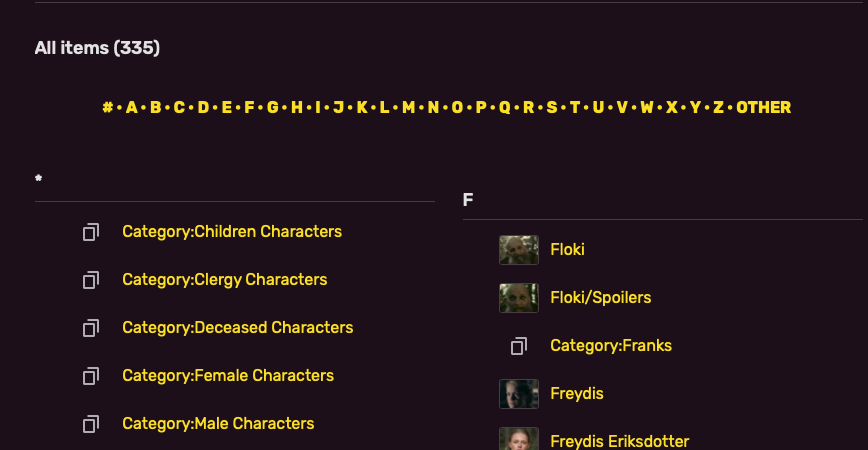



In [2]:
url = 'https://vikings.fandom.com/wiki/Category:Characters?from=' 
names_urls = {}

# iterate over the character listing pages
for prefix in ['', 'Leon']:
    url   = url + prefix
    sauce = urlopen(url).read()
    soup  = bs.BeautifulSoup(sauce,'lxml')
    
    # get the items from the character listing site
    chars = [s for s in soup.find_all('a', {'class' : 'category-page__member-link'}) if 'Category:' not in s.text]
    
    # extract character names and profile urls
    for c in chars:
        name = c.text.replace('/', '__')
        names_urls[name] = 'https://vikings.fandom.com' + str(c).split('href="')[1].split('" title')[0]
        urls_names = {n : u for u, n in names_urls.items()}
          
names_ids  = {n : u.replace('/Spoilers', '').split('/')[-1] for n, u in names_urls.items()}            

print('Number of characters collected:', len(urls_names))

Number of characters collected: 307


### 2. Collect character profiles

Next, for each character, I downloaded its profile page's source code using the same simple web scraping tools.

Source: https://vikings.fandom.com/wiki/Ragnar

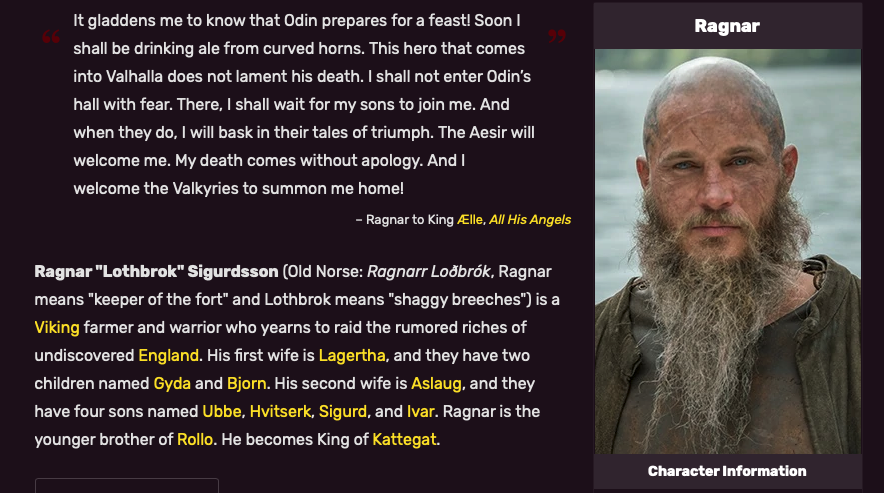

In [3]:
# output folder for the profile htmls
folderout = 'fandom_profiles'
if not os.path.exists(folderout):
    os.makedirs(folderout)
      
# crawl and save the profile htmls
for ind, (name, url) in enumerate(names_urls.items()):
    if not os.path.exists(folderout + '/' + name + '.html'):
        fout = open(folderout + '/' + name + '.html', "w")
        fout.write(str(urlopen(url).read()))
        fout.close()        

### 3. Extract references and build the network

As shown in the previous screenshot, characters' bios usually contain several references pointing to the bio of other characters whom their stories met. In this section, I extract these references from each crawled bio. Then, by using networkx, I transform these references into a network.

In [4]:
# extract the name mentions from the html sources
# and build the list of edges in a dictionary
edges = {}

for fn in [fn for fn in os.listdir(folderout) if '.html' in fn]:

    name = fn.split('.html')[0].split('__')[0].split(' (Vikin')[0]

    with open(folderout + '/' + fn) as myfile:
        text = myfile.read()
        soup  = bs.BeautifulSoup(text,'lxml')
        text = ' '.join([str(a) for a in soup.find_all('p')[2:]])
        soup = bs.BeautifulSoup(text,'lxml')
        
        for n, i in names_ids.items():
            
            n = n.split('__')[0].split(' (Vikin')[0]
            w = text.split('Image Gallery')[0].count('/' + i) 
            # there was a guy called Vik - as a substring of Viking it caused some issues
            if name == 'Vik' or n == 'Vik': w = w - text.count('Viking')

            if w>0:
                edge = '\t'.join(sorted([name, n]))
                if edge not in edges:
                    edges[edge] = w
                else:
                    edges[edge] += w

In [5]:
#  create the networkx graph from the dict of edges
G = nx.Graph()
for e, w in edges.items():
    if w>0:
        e1, e2 = e.split('\t')
        G.add_edge(e1, e2, weight=w)

G.remove_edges_from(nx.selfloop_edges(G))

print('Number of nodes: ', G.number_of_nodes())
print('Number of edges: ', G.number_of_edges())

Number of nodes:  221
Number of edges:  1104


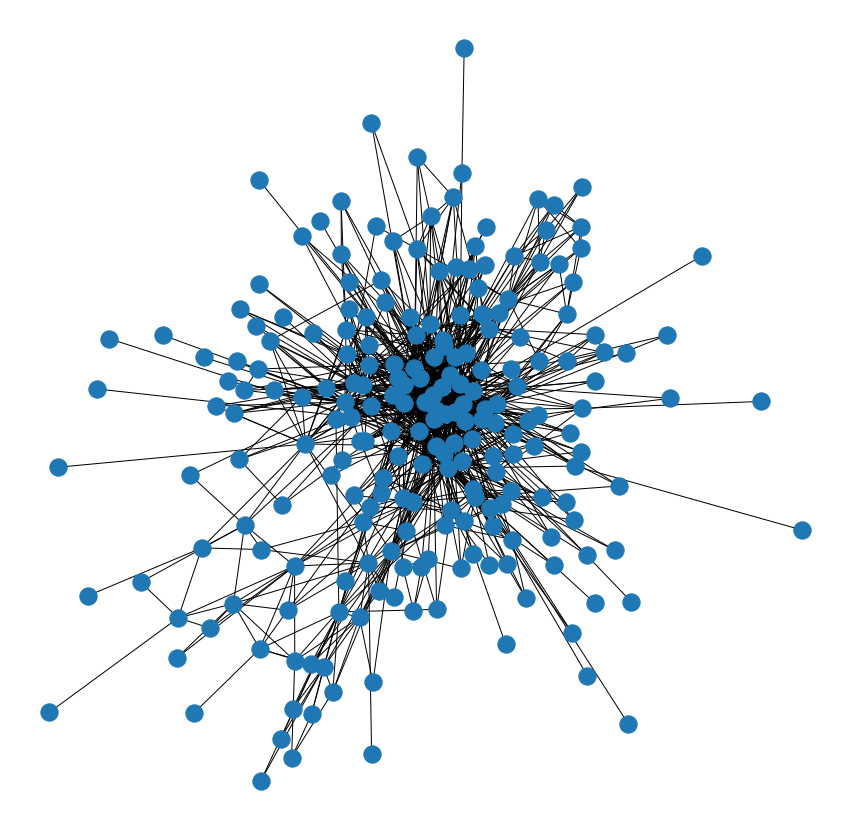

In [6]:
# take a very brief look at the network
f, ax = plt.subplots(1,1,figsize=(15,15))
nx.draw(G, ax=ax)

### 4. Visualizing the network with Gephi

Here I export the previously built network into a Gephi (https://gephi.org) file and create a much nicer visualization there.

In [7]:
nx.write_gexf(G, 'Vikings_network.gexf')

The raw, unformatted network:
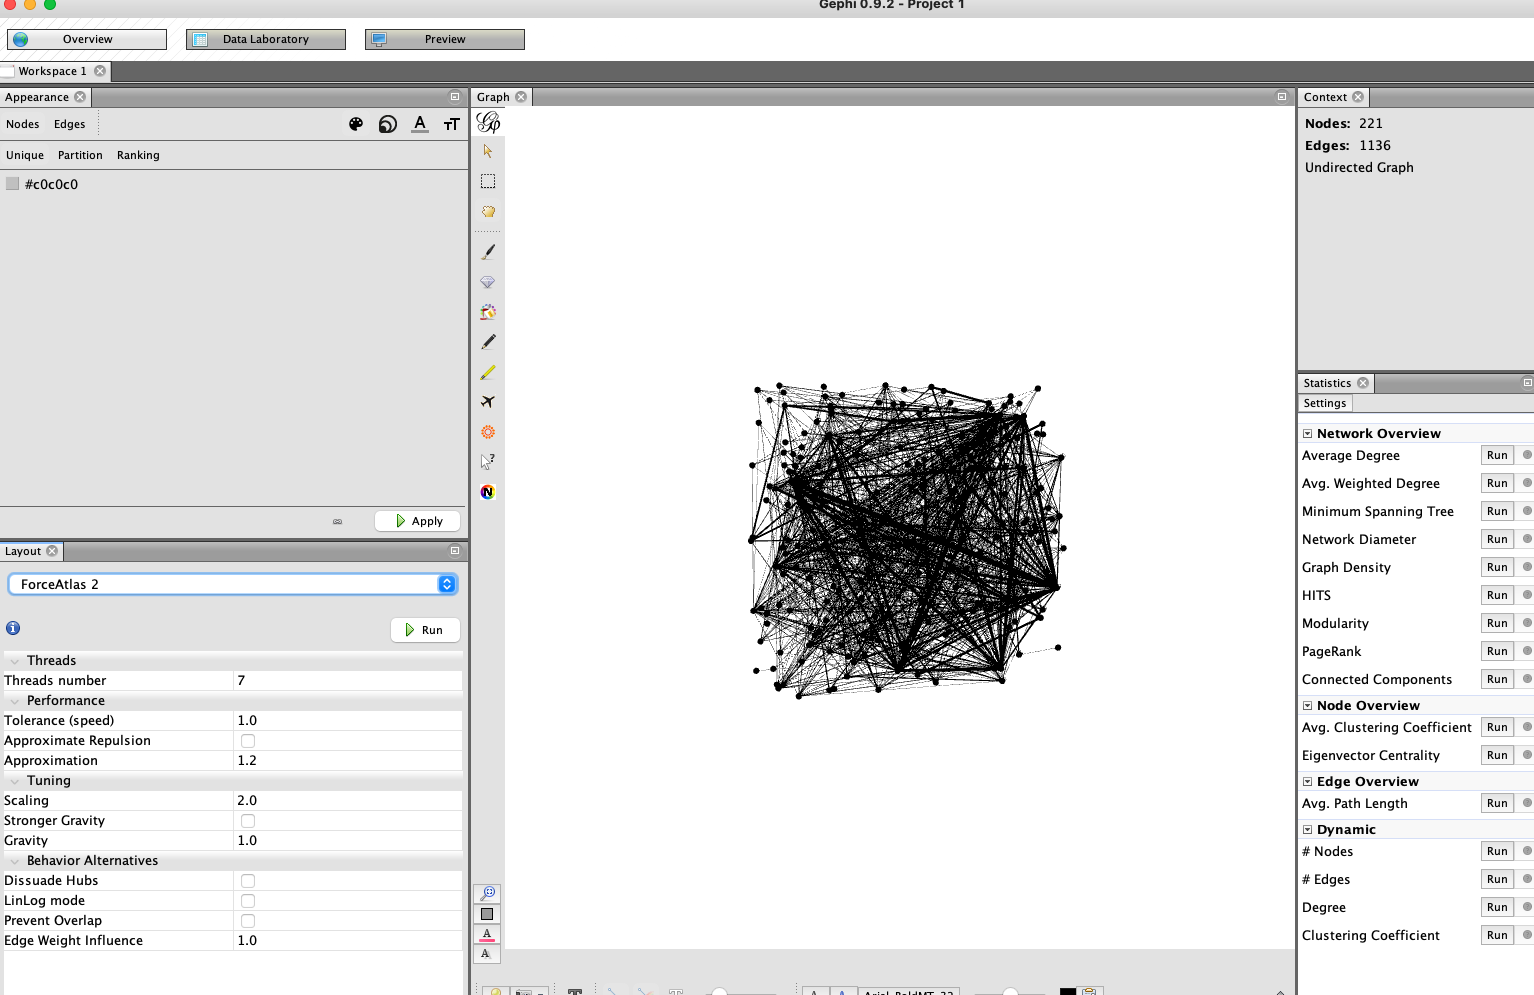   

The edited network:
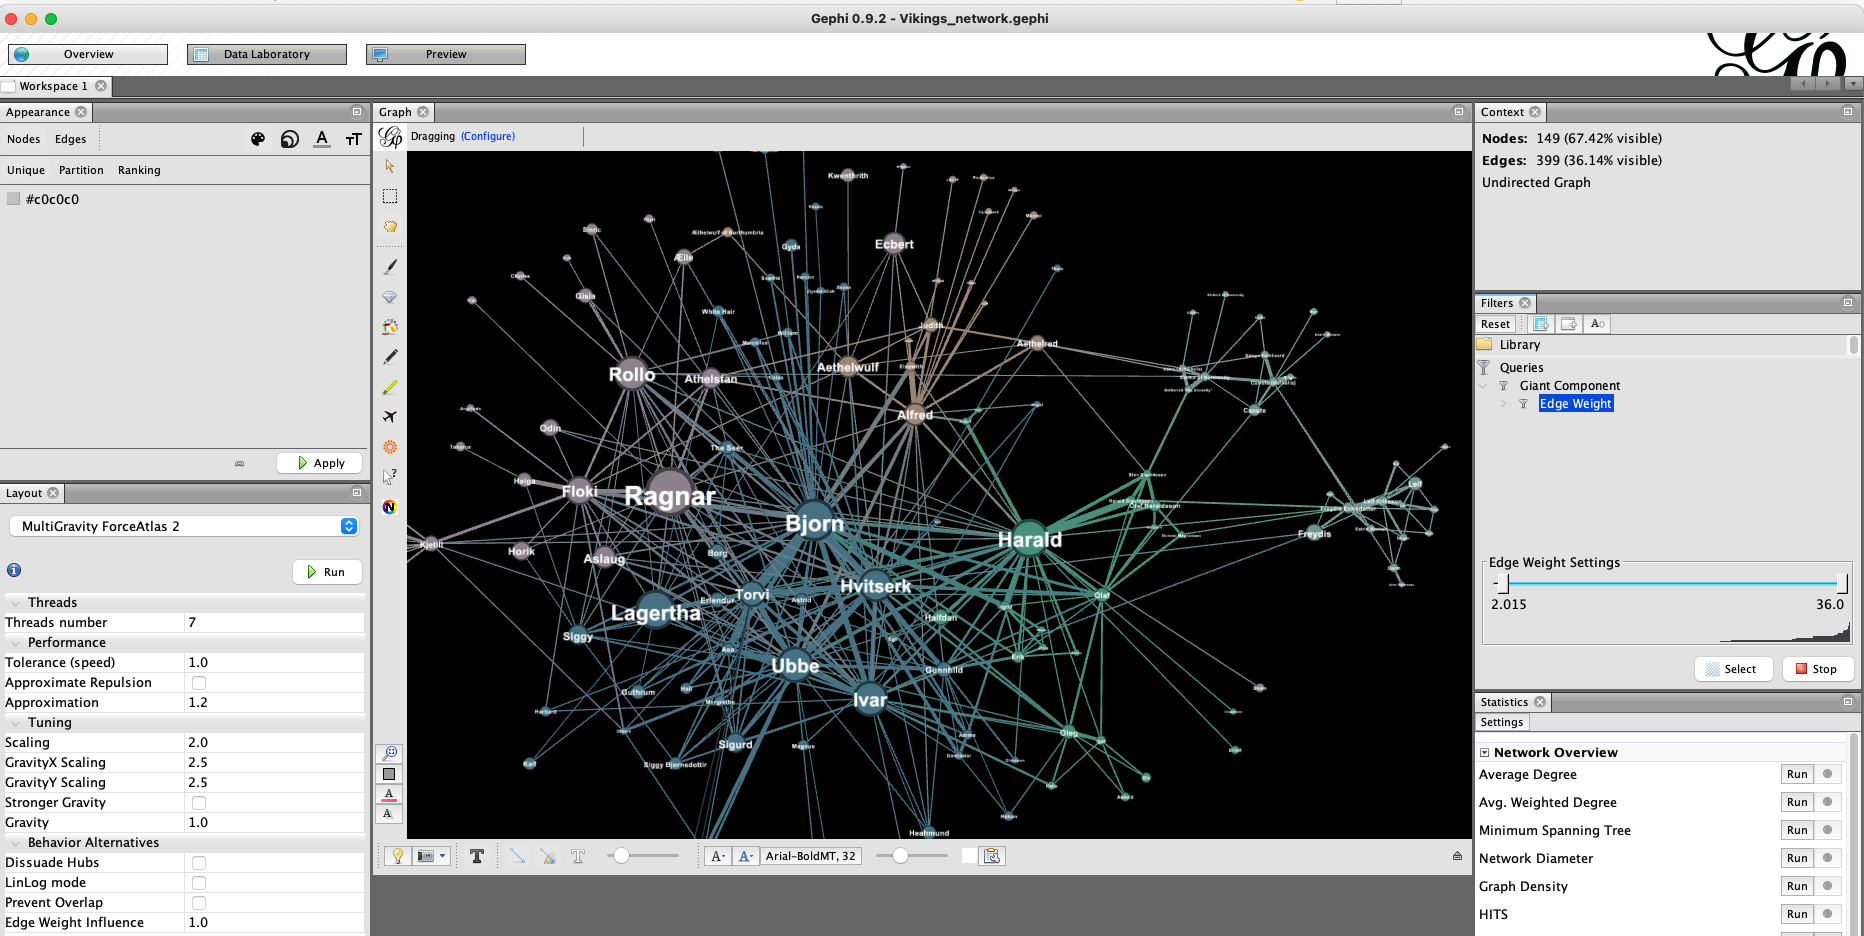

### 5. Simple network characteristics

Finally, further using networkx, I extracted basic node and edge properties to briefly characterize the Viking graph.

#### 5.1. Analyzing network nodes

In [8]:
# get the node degree distribution
nodes = sorted([(k, v) for k, v in dict(G.degree).items()], key=lambda tup: tup[1], reverse = True)
print('Top 10 most connected characters:', ', '.join([n[0] for n in nodes[0:10]]))

print('\n\nNumber of connections of the top characters:\n')
for n in nodes[0:10]:
    print(n[0], n[1])
    
# compute the number of links belonging to the top characters
print('\n\nFraction of connections relating to the top 10 characters:' , round(sum([n[1] for n in nodes[0:10]])/sum([n[1] for n in nodes]), 3))

Top 10 most connected characters: Ragnar, Bjorn, Lagertha, Harald, Ubbe, Ivar, Rollo, Hvitserk, Floki, Torvi


Number of connections of the top characters:

Ragnar 85
Bjorn 71
Lagertha 66
Harald 64
Ubbe 59
Ivar 58
Rollo 57
Hvitserk 54
Floki 45
Torvi 40


Fraction of connections relating to the top 10 characters: 0.271


In [9]:
for limit in [10, 5, 3]:
    print('Connection limit: ' + str(limit) + ', number of nodes: ', len([n for n in nodes if n[1]<limit]), len(nodes))

Connection limit: 10, number of nodes:  160 221
Connection limit: 5, number of nodes:  93 221
Connection limit: 3, number of nodes:  48 221


#### 5.2. Analyzing network edges

In [10]:
edges = sorted([(' - '.join(sorted([e[0], e[1]])), G.get_edge_data(e[0], e[1])['weight']) for e in G.edges], key=lambda tup: tup[1], reverse = True)
for ind, edge in enumerate(edges):
    print(ind+1, edge)

1 ('Bjorn - Torvi', 36)
2 ('Harald - Harald Sigurdsson', 24)
3 ('Alfred - Elsewith', 20)
4 ('Bjorn - Ivar', 20)
5 ('Hvitserk - Torvi', 20)
6 ('Hvitserk - Ubbe', 20)
7 ('Torvi - Ubbe', 20)
8 ('Freydis Eriksdotter - Leif Eriksson', 20)
9 ('Harald - Ingrid', 18)
10 ('Bjorn - Ingrid', 18)
11 ('Asa - Bjorn', 16)
12 ('Bjorn - Elsewith', 16)
13 ('Bjorn - Gunnhild', 16)
14 ('Bjorn - Hvitserk', 16)
15 ('Hvitserk - Ivar', 16)
16 ('Ivar - Ubbe', 16)
17 ('Asa - Ubbe', 16)
18 ('Asa - Torvi', 16)
19 ('Floki - Helga', 16)
20 ('Aethelred "the Unready" - Emma of Normandy', 16)
21 ('Canute (Valhalla) - Ælfgifu', 16)
22 ('Gudrid - Naad', 16)
23 ("Pekitaulet - We'jitu", 16)
24 ("Peminuit - We'jitu", 16)
25 ('Nikani - Peminuit', 16)
26 ('Pekitaulet - Peminuit', 16)
27 ('Bjorn - Floki', 14)
28 ('Floki - Ragnar', 13)
29 ('Aldulf - Harald', 12)
30 ('Bjorn - Harald', 12)
31 ('Harald - Hvitserk', 12)
32 ('Harald - Ubbe', 12)
33 ('Harald - Sten Sigurdsson', 12)
34 ('Alfred - Torvi', 12)
35 ('Alfred - Ubbe', 12)
